In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU!")
else:
    print("CUDA is not available. PyTorch will use the CPU.")


CUDA is available. PyTorch can use the GPU!


In [2]:
import pandas as pd

cleaned_df = pd.read_csv("cleaned_train.csv")

print(cleaned_df)

      Unnamed: 0  song_id   filename  genre_id                genre
0              0    10150  10150.wav         7         Instrumental
1              1     7358   7358.wav         2                 Punk
2              2    20573  20573.wav         5                 Folk
3              3    11170  11170.wav        12  Old-Time / Historic
4              4    16662  16662.wav         1                 Rock
...          ...      ...        ...       ...                  ...
19888      19917     9337   9337.wav         0           Electronic
19889      19918     8340   8340.wav         4              Hip-Hop
19890      19919    16248  16248.wav         4              Hip-Hop
19891      19920    11875  11875.wav         2                 Punk
19892      19921     6579   6579.wav         1                 Rock

[19893 rows x 5 columns]


In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np


def get_spectrogram(file_path, n_mels=128, duration=10, debug=False):
    samples, sample_rate = librosa.load(file_path, sr=None, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)  # Maybe we can play with n_mels here.
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibels.

    if debug == True:
        # Plot waveform
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(samples, sr=sample_rate)
        
        # Plot spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            librosa.power_to_db(spectrogram, ref=np.max), 
            y_axis='mel', 
            fmax=8000, 
            x_axis='time'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()

    return mel_spectrogram_db

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# This loads up the csv file and grabs the labels
# This can be run without messing up the features object

cleaned_df = pd.read_csv("cleaned_train.csv")
data = cleaned_df[["song_id", "genre"]]

labels = data.loc[:, "genre"]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [42]:
pd.Series(data.loc[:, "genre"]).value_counts()

genre
Rock                   3095
Electronic             3071
Punk                   2582
Experimental           1799
Hip-Hop                1756
Folk                   1214
Chiptune / Glitch      1181
Instrumental           1044
Pop                     944
International           814
Ambient Electronic      796
Classical               495
Old-Time / Historic     408
Jazz                    306
Country                 142
Soul-RnB                 94
Spoken                   94
Blues                    58
Name: count, dtype: int64

In [4]:
import pathlib
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor

# This is for grabbing the features. If you've already run this code block,
# You can save the features object in a pickle for future loading.

audio_dir = pathlib.Path("music-classification-wav/versions/3/IA/train/")

start_time = time.time()

song_ids = data.loc[:, "song_id"]
song_filepaths = [ audio_dir / (str(song_id) + ".wav") for song_id in song_ids]

def process_file(song_filepath):
    spectrogram = get_spectrogram(song_filepath, n_mels=128, debug=False)
    normalized_spectrogram = spectrogram / np.max(np.abs(spectrogram))  # Normalize
    return normalized_spectrogram

with ProcessPoolExecutor() as executor:
    features = list(executor.map(process_file, song_filepaths[0:]))


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

print("Length of features array: ", len(features))
print("Length of encoded_labels array: ", len(encoded_labels))

Elapsed time: 745.06 seconds
Length of features array:  19893
Length of encoded_labels array:  19893


In [3]:
import pickle

# If you've already run the above block of code and want to save the features variable, run this code block.
pickle_path = "features.pkl"
with open(pickle_path, 'wb') as file:
        pickle.dump(features, file)
loaded_features = features

In [ ]:
# If you already have saved the features in a pickle, you can use this code to load it back up.

pickle_path = "features.pkl"
with open('features.pkl', 'rb') as file:
    loaded_features = pickle.load(file)

In [5]:
import numpy as np
# Pad the spectrograms
max_width = max([mel.shape[1] for mel in loaded_features])

pads_applied = 0
def pad_spectrogram(mel, max_width):
    pad_width = max_width - mel.shape[1]
    if pad_width > 0:
        pads_applied +=1
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')

loaded_features = [pad_spectrogram(mel, max_width) for mel in loaded_features]
print(f"Pads applied: {pads_applied}")


Pads applied: 0


In [15]:
from torch.utils.data import Dataset
import pathlib


class AudioDataset(Dataset):
    def __init__(self, mel_spectrograms, genre_labels):
        self.mel_spectrograms = mel_spectrograms
        self.labels = genre_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.mel_spectrograms[idx]
        y = self.labels[idx]

        # Add channel dimension
        x = x.clone().detach().requires_grad_(True).unsqueeze(0)
        y = y.clone().detach().requires_grad_(False)
        #x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 646)
        #y = torch.tensor(y, dtype=torch.long)
            
        return x, y

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(loaded_features, encoded_labels, test_size=0.2, random_state=53)

In [58]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

In [63]:
import torch

# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

# Create PyTorch datasets
train_dataset = AudioDataset(X_train_tensor, y_train_tensor)
test_dataset = AudioDataset(X_test_tensor, y_test_tensor)

# Create PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [64]:
for inputs, labels in train_loader:
    print(inputs.shape)  # Should be (batch_size, 1, 128, int_dependent_upon_length_of_audio_file)
    break

torch.Size([64, 1, 128, 431])


In [65]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.5)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = None  # Placeholder for dynamic initialization
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass through conv and pool layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Shape: (batch_size, 32, height/2, width/2)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Shape: (batch_size, 64, height/4, width/4)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Shape: (batch_size, 128, height/8, width/8)

        # Dynamically initialize fc1 based on input size
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)  # Calculate flattened size
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [68]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
num_classes = len(label_encoder.classes_)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007, weight_decay=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

base_start_time = time.time()

model.to(device)  # Move the model to the GPU/CPU

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print("--" * 20)
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Elapsed Time: {elapsed_time:.2f} seconds")

print("--" * 30)
print("--" * 30)
# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
base_end_time = time.time()
base_elapsed_time = base_end_time - base_start_time
print(f"Total Elapsed Time: {base_elapsed_time:.2f} seconds")
print("--" * 30)
print("--" * 30)

----------------------------------------
Epoch 1, Loss: 2.0954339197840555
Epoch 1, Elapsed Time: 23.70 seconds
----------------------------------------
Epoch 2, Loss: 1.9306646173737614
Epoch 2, Elapsed Time: 23.72 seconds
----------------------------------------
Epoch 3, Loss: 1.8269891738891602
Epoch 3, Elapsed Time: 23.67 seconds
----------------------------------------
Epoch 4, Loss: 1.7863128496461125
Epoch 4, Elapsed Time: 23.75 seconds
----------------------------------------
Epoch 5, Loss: 1.7274642081624534
Epoch 5, Elapsed Time: 23.79 seconds
----------------------------------------
Epoch 6, Loss: 1.696515808143769
Epoch 6, Elapsed Time: 23.81 seconds
----------------------------------------
Epoch 7, Loss: 1.6374384030759574
Epoch 7, Elapsed Time: 23.81 seconds
----------------------------------------
Epoch 8, Loss: 1.6063715142897335
Epoch 8, Elapsed Time: 23.85 seconds
----------------------------------------
Epoch 9, Loss: 1.5641460816065471
Epoch 9, Elapsed Time: 23.83 s

Confusion Matrix:
[[  9   0   3   2   0  98  16   1  10  18   0   0   0   0   1   6   0   0]
 [  0   0   0   0   0   1   0   2   1   0   0   0   0   0   3   0   0   0]
 [  0   0  97   0   0  99  14   1  11   6   1   0   0   1   6   4   0   0]
 [  4   0   0  43   0   2  11   5   1  29   1   0   0   0   0   7   0   0]
 [  0   0   0   0   0   0   1   3   0   0   1   0   0   4   6  13   0   0]
 [  7   0  22   3   0 395  45   6  54  12   7   0   0   5  14  51   0   0]
 [  5   0   7   5   0  49 168   5  27  21   7   1   5   1  20  57   0   0]
 [  1   0   1   3   0   8   8 118   3  15   8   0   2   5  13  35   0   0]
 [  0   0   2   0   0  72   8   2 249   1   3   0   0   1   9   8   0   0]
 [  7   0   0  14   0  39  26  12   4  77   0   0   1   2   6  32   0   0]
 [  0   0   4   0   0  35   7  15  20   1  44   0   1   8   9  25   0   0]
 [  1   0   0   2   0   8   5   1   2   9   8   0   1   1   4  10   0   0]
 [  0   0   0   1   0   0   4   0   0   0   2   0  72   0   0   0   0   0]
 [  3  

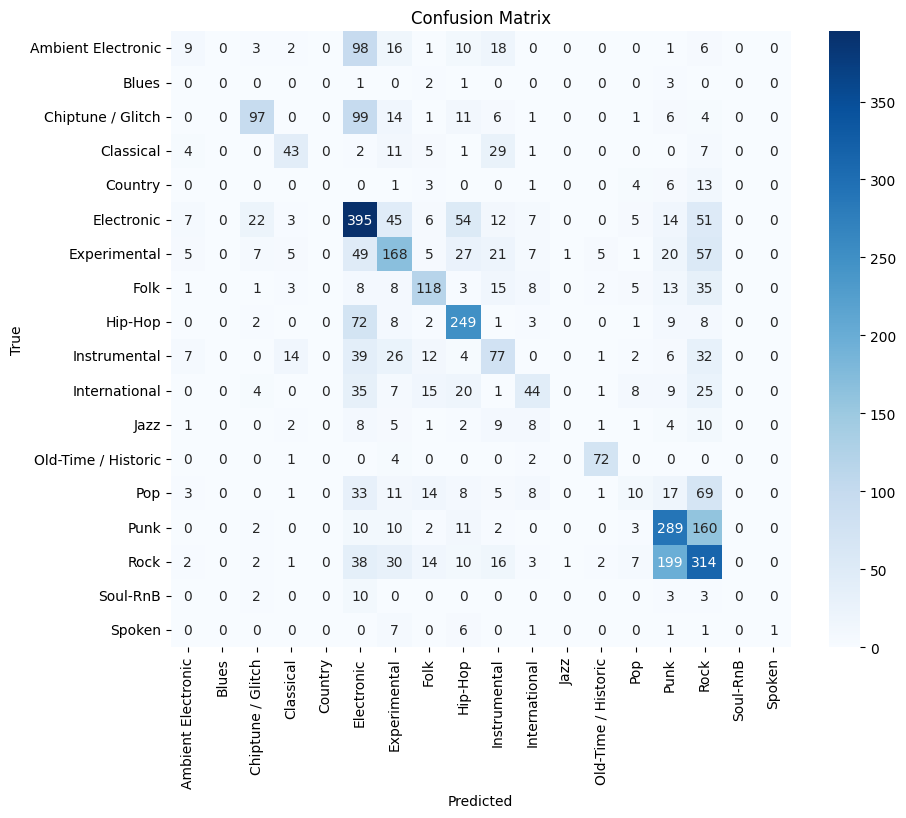

Classification Report:
                     precision    recall  f1-score   support

 Ambient Electronic       0.23      0.05      0.09       164
              Blues       0.00      0.00      0.00         7
  Chiptune / Glitch       0.68      0.40      0.51       240
          Classical       0.57      0.42      0.48       103
            Country       0.00      0.00      0.00        28
         Electronic       0.44      0.64      0.52       621
       Experimental       0.45      0.44      0.45       378
               Folk       0.59      0.54      0.56       220
            Hip-Hop       0.60      0.70      0.65       355
       Instrumental       0.36      0.35      0.36       220
      International       0.47      0.26      0.33       169
               Jazz       0.00      0.00      0.00        52
Old-Time / Historic       0.85      0.91      0.88        79
                Pop       0.21      0.06      0.09       180
               Punk       0.48      0.59      0.53       489


/home/deus/Development/JupyterNotebooks/audio-clusters/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/deus/Development/JupyterNotebooks/audio-clusters/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/deus/Development/JupyterNotebooks/audio-clusters/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [56]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []
all_labels = []

# Switch model to evaluation mode
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        labels = labels.to(device)  # Move labels to GPU if available
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        all_preds.extend(preds.cpu().numpy())  # Convert predictions to NumPy
        all_labels.extend(labels.cpu().numpy())  # Convert labels to NumPy

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Add class names to the confusion matrix.
class_names = label_encoder.classes_
plot_confusion_matrix(cm, class_names)

# Print a classification report.
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [ ]:
from torch.utils.data import Dataset
import pathlib


class AudioDataset(Dataset):
    def __init__(self, audio_dir, song_ids, genre_ids n_mels=128, normalize=True, transform=None, target_transform=None):
        self.data = pd.DataFrame([song_ids, genre_ids], columns=["song_id", "genre_id"])
        self.transform = transform
        self.target_transform = target_transform
        
        self.n_mels = n_mels
        self.audio_features, self.genre_labels = [], []
        for i in range(0, self.data.shape[0]):
            song_id = data.iloc[i]["song_id"]
            song_filename = str(song_id) + ".wav"
            song_filepath = audio_dir / song_filename
            
            spectrogram = self.get_spectrogram(song_filepath, n_mels=n_mels, debug=False)
            if normalize is True:
                spectrogram = self.normalize(spectrogram)
                
            if self.transform is not None:
                spectrogram = self.transform(spectrogram)
                
            features.append(normalized_spectrogram)

    def __len__(self):
        return len(self.genre_labels)

    def __getitem__(self, idx):
        song_features = self.audio_features[idx]
        genre_label = self.genre_labels[idx]
            
        return song_features, genre_label

    def get_spectrogram(self, file_path, n_mels= 128, debug=False):
        samples, sample_rate = librosa.load(file_path, sr=None, duration=15)
        mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)  # Maybe we can play with n_mels here.
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibels.

        if debug == True:
            # Plot waveform
            plt.figure(figsize=(14, 5))
            librosa.display.waveshow(samples, sr=sample_rate)
        
            # Plot spectrogram
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(
                librosa.power_to_db(spectrogram, ref=np.max), 
                y_axis='mel', 
                fmax=8000, 
                x_axis='time'
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel spectrogram')
            plt.tight_layout()

        return mel_spectrogram_db

    def normalize(self, spectrogram):
        normalized_spectrogram = spectrogram / np.max(np.abs(spectrogram))
        return normalized_spectrogram
        